In [0]:
# !rm -rf SinGAN_Object_Completion
# !rm *.py
# !rm *.jpg
# !rm -rf vision
# !rm -rf coco*

In [0]:
from PIL import Image
import os
import numpy as np
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!git clone https://github.com/manorzvi/SinGAN_Object_Completion.git

fatal: destination path 'SinGAN_Object_Completion' already exists and is not an empty directory.


In [5]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

fatal: destination path 'cocoapi' already exists and is not an empty directory.
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/mask.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/cocoeval.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.l

In [6]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from SinGAN_Object_Completion import fastrcnn_mask_functions

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = fastrcnn_mask_functions.get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

In [0]:
singan_dir = '/content/gdrive/My Drive/singan/SinGAN'
models_dir = os.path.join(singan_dir, 'models')
images_dir = os.path.join(singan_dir, 'Input/People')
masks_dir  = os.path.join(singan_dir, 'Input/Masks')
assert os.path.exists(singan_dir)
assert os.path.exists(models_dir)
assert os.path.exists(images_dir)
assert os.path.exists(masks_dir)

model_name = 'fastrcnn_segmentation_model_12012019-184816.pth'
model_path = os.path.join(models_dir, model_name)
assert os.path.exists(model_path)

image_name = 'nature7.jpg'
image_path = os.path.join(images_dir, image_name)
assert os.path.exists(image_path)

In [10]:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

In [0]:
import transforms as T
image = Image.open(image_path).convert("RGB")
image, _ = T.ToTensor()(image, None)

with torch.no_grad(): 
  prediction = model([image.to(device)])

In [12]:
prediction

[{'boxes': tensor([[1983.8966, 2545.9827, 2316.4382, 3431.2261],
          [1539.8466, 2638.3701, 1849.2626, 3431.7800]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
  'scores': tensor([0.9961, 0.9952], device='cuda:0')}]

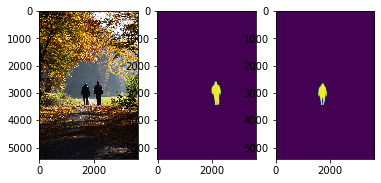

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,prediction[0]['masks'].shape[0]+1)
axes[0].imshow(Image.fromarray(image.mul(255).permute(1, 2, 0).byte().numpy()))
for i in range(prediction[0]['masks'].shape[0]):
  axes[i+1].imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))

In [14]:
bin_treshold = 0.01
ones  = torch.ones_like(prediction[0]['masks'])
zeros = torch.zeros_like(prediction[0]['masks'])  
masks = torch.where(prediction[0]['masks'] < bin_treshold, ones, zeros)
masks

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')

In [15]:
masks_names = fastrcnn_mask_functions.create_names(image_name=image_name, name='mask',
                                                   amount=prediction[0]['masks'].shape[0])
fastrcnn_mask_functions.save_here(images=masks, images_names=masks_names)
fastrcnn_mask_functions.save2drive(dir_path=masks_dir, images_names=masks_names)

Save nature7_mask_0.jpg here...  Done.
Save nature7_mask_1.jpg here...  Done.
Save nature7_mask_0.jpg to drive...  Done.
Save nature7_mask_1.jpg to drive...  Done.


In [16]:
from google.colab import files
for mask_name in masks_names:
  print('Download {} to Local... '.format(mask_name), end=' ')
  files.download(mask_name)
  print('Done.')

Download nature7_mask_0.jpg to Local...  Done.
Download nature7_mask_1.jpg to Local...  Done.


In [17]:
masked_names = fastrcnn_mask_functions.create_names(image_name=image_name, name='masked',
                                                  amount=prediction[0]['masks'].shape[0])
fastrcnn_mask_functions.apply_mask(masks=masks, image=image, names_to_save=masked_names, device=device,
                                   to_save_in_drive=True, drive_path=masks_dir)

Save nature7_masked_0.jpg here...  Done.
Save nature7_masked_1.jpg here...  Done.
Save nature7_masked_0.jpg to drive...  Done.
Save nature7_masked_1.jpg to drive...  Done.


In [18]:
from google.colab import files
for masked_name in masked_names:
  print('Download {} to Local... '.format(masked_name), end=' ')
  files.download(masked_name)
  print('Done.')

Download nature7_masked_0.jpg to Local...  Done.
Download nature7_masked_1.jpg to Local...  Done.


In [19]:
h_offset = 800
v_offset = 0

patched_names = fastrcnn_mask_functions.create_names(image_name=image_name, name='patched',
                                                  amount=prediction[0]['masks'].shape[0])
for i, name in enumerate(patched_names):
  mask = masks[i,:,:,:]
  fastrcnn_mask_functions.apply_patch(mask=mask, image=image, name_to_save=name, device=device,
                offset_h=h_offset, offset_v=v_offset, drive_path=masks_dir)

Save nature7_patched_0.jpg here...  Done.
Save nature7_patched_1.jpg here...  Done.


In [22]:
from google.colab import files
for patched_name in patched_names:
  print('Download {} to Local... '.format(patched_name), end=' ')
  files.download(patched_name)
  print('Done.')

Download nature7_patched_0.jpg to Local...  Done.
Download nature7_patched_1.jpg to Local...  Done.


In [0]:
# os.chdir('SinGAN_Object_Completion')
# !pwd

In [0]:
# !git pull



In [0]:
# os.chdir('../')
# !pwd